# Проект ML в бизнесе: Выбор локации для скважины

От добывающей компании «ГлавРосГосНефть» предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap. 

**Цель исследования**: Определить наиболее перспективный регион для бурения новой нефтяной скважины на основе предсказательной модели, оценки возможной прибыли и анализа рисков.

**Задачи исследования**:  

- Загрузить и подготовить данные трёх регионов.
- Обучить линейную регрессионную модель для предсказания объёма запасов нефти в каждой скважине.
- Оценить качество модели на валидационной выборке по метрике RMSE и среднему предсказанному значению.
- Рассчитать потенциальную прибыль от разработки 200 лучших скважин в каждом регионе.
- Оценить риски и прибыль с использованием бутстрапа:
    - Построить распределение прибыли.
    - Рассчитать среднюю прибыль, доверительный интервал и вероятность убытков.
- Принять решение о выборе региона с учётом прибыли и допустимого уровня риска.

**Описание данных**:  

Данные геологоразведки для трёх регионов содержатся в файлах:

*/datasets/geo_data_0.csv*  
*/datasets/geo_data_1.csv*  
*/datasets/geo_data_2.csv*  

Каждый файл содержит:  

*id* — уникальный идентификатор скважины.  
*f0, f1, f2* — признаки (характеристики) месторождения.  
*product* — целевой признак: объём запасов нефти в скважине (в тыс. баррелей).

In [1]:
# импорт используемых библиотек

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import warnings

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Загрузка и подготовка данных

In [3]:
geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [4]:
# функция для получения базовой информации о датасетах

def get_info(df):
    print("Размер датасета:", df.shape, sep='\n', end='\n\n')
    display(df)
    print('\n')
    display(df.info())
    print('\n')
    display(df.describe().T)
    print("Количество пропусков:", df.isna().sum(), sep='\n', end='\n\n')
    print("Количество явных дубликатов:", df.duplicated().sum(), end='\n\n')
    display(df[df.duplicated() == True])

In [5]:
get_info(geo_data_0)

Размер датасета:
(100000, 5)



,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


Количество пропусков:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество явных дубликатов: 0



,id,f0,f1,f2,product


In [6]:
get_info(geo_data_1)

Размер датасета:
(100000, 5)



,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


Количество пропусков:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество явных дубликатов: 0



,id,f0,f1,f2,product


In [7]:
get_info(geo_data_2)

Размер датасета:
(100000, 5)



,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


Количество пропусков:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество явных дубликатов: 0



,id,f0,f1,f2,product


Данные чистые, пропуски и дубликаты отсутствуют, типы данных соответствуют представленным. Во всех датасетах равное количество значений. 

In [8]:
geo_data_0 = geo_data_0.drop(columns=['id'], axis=0)
geo_data_1 = geo_data_1.drop(columns=['id'], axis=0)
geo_data_2 = geo_data_2.drop(columns=['id'], axis=0)

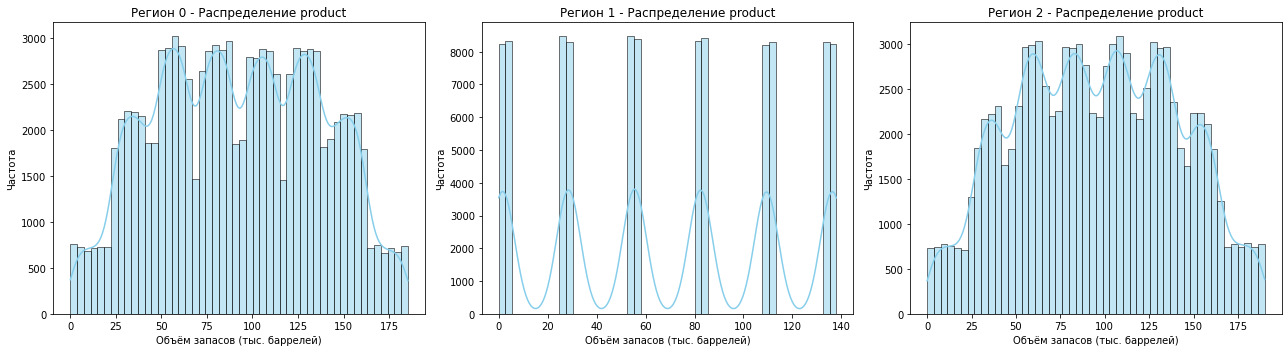

In [9]:
# визуализация целевого признака

plt.figure(figsize=(18, 5))

for i, data in enumerate([geo_data_0, geo_data_1, geo_data_2]):
    plt.subplot(1, 3, i+1)
    sns.histplot(data['product'], bins=50, kde=True, color='skyblue')
    plt.title(f'Регион {i} - Распределение product')
    plt.xlabel('Объём запасов (тыс. баррелей)')
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

В первом и третьем регионе распределение объема запасов похоже на нормальное, но с несколькими пиками. Диапазон: От ~0 до 180 тыс. баррелей. 

А вот во втором регионе распределение странное: чётко выраженные пики с регулярными интервалами и почти нулевая частота между ними. Напоминает синтетические данные. Модель может переобучаться или застревать на повторяющихся значениях.

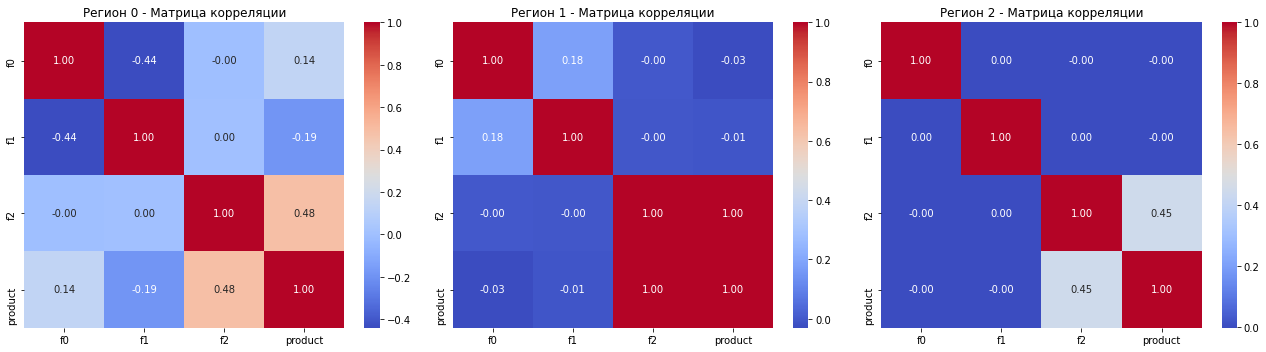

In [10]:
plt.figure(figsize=(18, 5))

for i, data in enumerate([geo_data_0, geo_data_1, geo_data_2]):
    plt.subplot(1, 3, i+1)
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Регион {i} - Матрица корреляции')

plt.tight_layout()
plt.show()

В регионе 0: f2: ~ 0.48 — единственный, кто показывает умеренную положительную корреляцию с целевым признаком. Такая же ситуация и с регионом 2. 

А в регионе 1 product можно почти точно выразить через f2, корреляция равна 1. Однако стоит быть осторожными, либо это особенность данных (например, product был рассчитан напрямую из f2), либо это утечка данных.  

f2 — основной и возможно единственный полезный признак для предсказания product.

### Вывод.

- Данные корректны: отсутствуют пропуски и дубликаты, типы признаков соответствуют представленным.
- Объём данных по каждому региону одинаковый, позволяет проводить равноправное сравнение.
- Распределение целевого признака product:
  - В регионах 0 и 2 — близко к нормальному.
  - В регионе 1 — синтетическое, с резкими пиками и повторяющимися значениями. Это может повлиять на стабильность модели.
- Анализ корреляции показал, что только признак f2 имеет значимую связь с product:
  - В регионах 0 и 2 — умеренная положительная корреляция (~0.48, 0.45).
  - В регионе 1 — корреляция 1.00, что указывает на потенциальную утечку данных.

**Вывод:** данные подходят для обучения модели линейной регрессии, однако в регионе 1 следует тщательно проверить признаки, чтобы исключить утечку информации из целевого признака.

## 2. Обучение модели

In [11]:
def process_region(data, region_name):
    print(f"\nРегион {region_name}")
    
    # разделение данных
    features = data.drop(columns=['product'])
    target = data['product']
    X_train, X_valid, y_train, y_valid = train_test_split(
        features, target, test_size=0.25, random_state=42)
    
    # обучение модели
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])
    model.fit(X_train, y_train)

    # предсказания
    predictions = model.predict(X_valid)
    y_valid = y_valid.reset_index(drop=True)
    predictions = pd.Series(predictions)

    # средний запас и RMSE
    mean_predicted = predictions.mean()
    rmse = mean_squared_error(y_valid, predictions, squared=False)
    print(f"Средний предсказанный запас: {mean_predicted:.2f} тыс. барр.")
    print(f"RMSE модели: {rmse:.2f}")

    return predictions, y_valid

In [12]:
preds_0, target_0 = process_region(geo_data_0, '0')
preds_1, target_1 = process_region(geo_data_1, '1')
preds_2, target_2 = process_region(geo_data_2, '2')


Регион 0
Средний предсказанный запас: 92.40 тыс. барр.
RMSE модели: 37.76

Регион 1
Средний предсказанный запас: 68.71 тыс. барр.
RMSE модели: 0.89

Регион 2
Средний предсказанный запас: 94.77 тыс. барр.
RMSE модели: 40.15


### Вывод

- Для каждого региона обучена модель линейной регрессии с масштабированием признаков.
- Результаты модели на валидационной выборке:
  - **Регион 0**: средний предсказанный запас — **92.4 тыс. барр.**, RMSE — **37.76**
  - **Регион 1**: средний предсказанный запас — **68.7 тыс. барр.**, RMSE — **0.89**
  - **Регион 2**: средний предсказанный запас — **94.8 тыс. барр.**, RMSE — **40.15**

- Для **региона 1** RMSE маленькая и почти идеально совпадает с реальными значениями — это подтверждает подозрение на утечку данных (идеальная линейная зависимость между f2 и product).

- Модели для регионов 0 и 2 выглядят более реалистично и пригодно для оценки рисков.

- Средний предсказанный запас у **региона 2 — самый высокий**.


## 3. Подготовка к расчету прибыли

In [13]:
BUDGET = 10_000_000_000  # общий бюджет
OIL_WELLS = 200          # количество лучших скважин
PROFIT = 450_000         # доход с 1 барреля сырья

ONE_WELL = BUDGET / OIL_WELLS
print('Объём сырья для окупаемости одной скважины:', ONE_WELL / PROFIT)

Объём сырья для окупаемости одной скважины: 111.11111111111111


In [14]:
mean_targets = {
    'Регион 0': target_0.mean(),
    'Регион 1': target_1.mean(),
    'Регион 2': target_2.mean()
}

for region, mean_volume in mean_targets.items():
    print(f"{region} — средний фактический объём: {mean_volume:.2f} тыс. баррелей")

Регион 0 — средний фактический объём: 92.33 тыс. баррелей
Регион 1 — средний фактический объём: 68.73 тыс. баррелей
Регион 2 — средний фактический объём: 95.15 тыс. баррелей


### Вывод

Средние фактические объёмы сырья по регионам:
- **Регион 0** — 92.33 тыс. баррелей
- **Регион 1** — 68.73 тыс. баррелей
- **Регион 2** — 95.15 тыс. баррелей

**Вывод:** ни один регион в среднем **не достигает порога безубыточности**. Однако регионы 0 и 2 приближаются к этой границе и могут оказаться прибыльными при выборе 200 лучших скважин, поэтому мы все равно расчитаем прибыль. 
**Регион 1 существенно отстаёт** — как по средним запасам, так и по достоверности модели.


## 4. Расчет прибыли

In [16]:
def analyze_best_wells(region_name, predictions, target, count):
    predictions = predictions.reset_index(drop=True)
    target = target.reset_index(drop=True)
    
    top_indices = predictions.sort_values(ascending=False).index[:count]
    selected_target = target[top_indices]
    
    total_oil = selected_target.sum()
    total_profit = total_oil * PROFIT - BUDGET

    print(f'Регион {region_name}')
    print(f'Суммарный объём сырья лучших {count} скважин: {total_oil:.2f} тыс. барр.')
    print(f'Прибыль от лучших скважин: {total_profit:.2f} руб.')
    print('-' * 50)

analyze_best_wells(0, preds_0, target_0, OIL_WELLS)
analyze_best_wells(1, preds_1, target_1, OIL_WELLS)
analyze_best_wells(2, preds_2, target_2, OIL_WELLS)

Регион 0
Суммарный объём сырья лучших 200 скважин: 29686.98 тыс. барр.
Прибыль от лучших скважин: 3359141114.46 руб.
--------------------------------------------------
Регион 1
Суммарный объём сырья лучших 200 скважин: 27589.08 тыс. барр.
Прибыль от лучших скважин: 2415086696.68 руб.
--------------------------------------------------
Регион 2
Суммарный объём сырья лучших 200 скважин: 27996.83 тыс. барр.
Прибыль от лучших скважин: 2598571759.37 руб.
--------------------------------------------------


### Вывод

Для каждого региона был рассчитан объём сырья и прибыль от 200 лучших скважин по предсказаниям модели:

- **Регион 0**:
  - Суммарный объём сырья лучших 200 скважин: **29,686.98 тыс. барр.**
  - Прибыль: **3,36 млрд руб.**

- **Регион 1**:
  - Суммарный объём сырья лучших 200 скважин: **27,589.08 тыс. барр.**
  - Прибыль: **2,42 млрд руб.**

- **Регион 2**:
  - Суммарный объём сырья лучших 200 скважин: **27,996.83 тыс. барр.**
  - Прибыль: **2,6 млрд руб.**

**Вывод:**
- **Регион 0** демонстрирует наибольшую прибыль, составляющую **3.36 млрд руб.** — это самый перспективный регион для разработки, несмотря на то, что средний объём сырья меньше порога безубыточности.
- **Регион 1** показывает наименьшую прибыль, меньший объем сырья и ненадежная модель.
- **Регион 2** также имеет хорошую прибыль, но уступает региону 0.

## 5. Риски и прибыль для каждого региона

In [17]:
def revenue(target, predictions, count=OIL_WELLS):
    top_indices = predictions.sort_values(ascending=False).index[:count]
    selected_target = target.loc[top_indices]
    return selected_target.sum() * PROFIT - BUDGET

In [18]:
def bootstrap(target, predictions, region_name):
    bootstrap_samples = 1000
    state = np.random.RandomState(12345)
    values = []

    data = pd.DataFrame({'target': target, 'predictions': predictions}).reset_index(drop=True)

    for i in range(bootstrap_samples):
        sample = data.sample(n=500, replace=True, random_state=state)
        values.append(revenue(sample['target'], sample['predictions']))

    values = pd.Series(values)
    mean = values.mean()
    lower = values.quantile(.025)
    upper = values.quantile(.975)

    print(f"[Регион {region_name}]")
    print("Средняя выручка, млн.руб.:", mean)
    print("Доверительный интервал, минимум:", lower)
    print("Доверительный интервал, максимум:", upper)
    print("Риски убытка:", (values < 0).mean())
    
    ax = values.plot(kind='hist', bins=10, grid=True, title=f'Гистограмма прибыли — Регион {region_name}')
    ax.set_xlabel('Прибыль, млн.руб.', fontsize=10)
    plt.show()

[Регион 0]
Средняя выручка, млн.руб.: 615047004.394259
Доверительный интервал, минимум: -20884982.29624209
Доверительный интервал, максимум: 1239730575.9180634
Риски убытка: 0.03


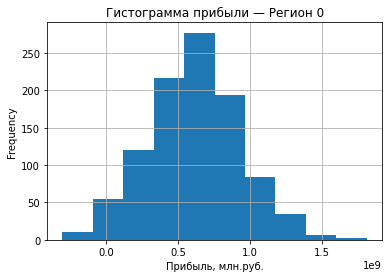

[Регион 1]
Средняя выручка, млн.руб.: 639637181.1031605
Доверительный интервал, минимум: 142332783.31613287
Доверительный интервал, максимум: 1195489473.2361748
Риски убытка: 0.004


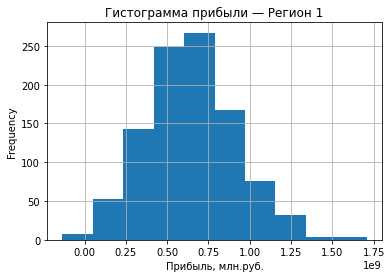

[Регион 2]
Средняя выручка, млн.руб.: 587106344.7958653
Доверительный интервал, минимум: -8459142.891548958
Доверительный интервал, максимум: 1283241366.0123456
Риски убытка: 0.026


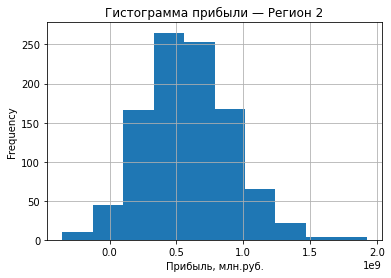

In [19]:
bootstrap(target_0, preds_0, '0')
bootstrap(target_1, preds_1, '1')
bootstrap(target_2, preds_2, '2')

### Вывод

1. **Регион 0**:
   - Средняя прибыль: **615.05 млн руб.**
   - 95%-й доверительный интервал: от -20.88 млн руб. до 1,239.73 млн руб
   - Вероятность убытков: **3%** 

2. **Регион 1**:
   - Средняя прибыль: **639.64 млн руб.**
   - 95%-й доверительный интервал: от 142.33 млн руб. до 1,195.49 млн руб.
   - Вероятность убытков: **0.4%** 

3. **Регион 2**:
   - Средняя прибыль: **587.11 млн руб.**
   - 95%-й доверительный интервал: от -8.46 млн руб. до 1,283.24 млн руб.
   - Вероятность убытков: **меньше 2.6%** 

## Вывод

**Регионы и их потенциальная прибыль:**  

1. Регион 0: Наибольшая прибыль (3.36 млрд руб.) и самый высокий риск убытков (3%). Регион 0 остаётся лучшим вариантом с точки зрения прибыли, несмотря на высокий риск.  

2. Регион 1: Наименьшая прибыль (2.42 млрд руб.) и ненадёжная модель (потенциальная утечка данных).

3. Регион 2: Хорошая прибыль (2.6 млрд руб.) и риски убытков в пределах 2.6%. Регион 2 является вторым по привлекательности после региона 0.  

Если выбирать из наименее рискованных регионов с наибольшей прибылью - лучшим вариантом будет регион 0. Вторым в "топе" являеся регион 2, а вот регион 1 - самый непредсказуемый. 